In [1]:
#头文件输入
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.model_selection import train_test_split
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u 
import pandas as pd
import os
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils import np_utils
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
#获取光谱数据
path_qso=pd.read_csv('02/qso.csv',header=None,delimiter=' ')
path_star=pd.read_csv('02/star.csv',header=None,delimiter=' ')
path_qso=np.array(path_qso)
path_star=np.array(path_star)
print(path_qso[1])
print(path_star[1])

['lamost_dr7_qso' 184.31142 36.727183000000004 '004392-2-00229'
 '../../lamost_dr7_qso/lamost_spectra/spec-58515-HD122712N362227M02_sp14-185.fits.gz']
['lamost_dr7_star' 115.51811000000001 22.676773999999998 '002887-4-00032'
 '../../lamost_dr7_star/lamost_spectra/spec-57005-GAC116N20B2_sp11-172.fits.gz']


In [3]:
data=fits.open(path_qso[0][4],ignore_missing_end=True)

In [4]:
#保存类星体的光谱数据
data_qso = np.zeros((len(path_qso),3700))
#防止有的文件不存在。
j=0

for i in range(len(path_qso)):
    data=fits.open(path_qso[i][4],ignore_missing_end=True)
    data_qso[i][:]=data[0].data[0][0:3700]
    j=j+1
print(j)

16463


In [5]:
#保存恒星的光谱数据
data_star = np.zeros((len(path_star),3700))
#防止有的文件不存在。
j=0

for i in range(len(path_star)):
    data=fits.open(path_star[i][4],ignore_missing_end=True)
    data_star[i][:]=data[0].data[0][0:3700]
    j=j+1
print(j)

8255


In [6]:
#对数据进行归一化
import math
feature=3700

def nom_flow(data):             
    for i in range(data.shape[0]):
        sum=0
        for j in range(feature):
            sum=sum+data[i,j]**2
        for j in range(feature):
            data[i,j]=data[i,j]/math.sqrt(sum)
nom_flow(data_qso)
nom_flow(data_star)

In [7]:
#设置标签
label=[]

#qso标签
for i in range(len(data_qso)):
    label.append(1)

#star标签
for i in range(len(data_star)):
    label.append(0)

label=np.array(label)
data=np.concatenate((data_qso,data_star),axis=0)
np.savetxt('03/data.csv',data,fmt='%.18f')
np.savetxt('03/label.csv',label,fmt='%.18f')

In [8]:
label.shape

(24718,)

In [9]:
print(len(data))

24718


In [10]:
data=pd.read_csv('03/data.csv',header=None,delimiter=' ')
label=pd.read_csv('03/label.csv',header=None)
data=np.array(data)
label=np.array(label)
print(label.shape,data.shape)

(24718, 1) (24718, 3700)


In [11]:
print(type(data[1][2]))

<class 'numpy.float64'>


In [12]:
#分割数据集，划分训练集和验证集
import sklearn.model_selection
from sklearn.model_selection import train_test_split
X = np.zeros(data.shape)
X[:,:] = data
y = label
y = np_utils.to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3)

In [13]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(17302, 3700) (7416, 3700) (17302, 2) (7416, 2)


In [14]:
y[1]

array([0., 1.], dtype=float32)

In [15]:
#构造网络
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.utils import np_utils
import tensorflow.keras.backend as K
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.models import Model
import tensorflow.python.keras
from tensorflow.python.keras.layers import Permute
from tensorflow.python.keras import initializers

def BLOCK(seq, filters): # 定义网络的Block
    cnn = Conv1D(filters, 3, padding='SAME', dilation_rate=1, activation='relu')(seq)
    cnn = Conv1D(filters, 3, padding='SAME', dilation_rate=2, activation='relu')(cnn)
    cnn = Conv1D(filters, 3, padding='SAME', dilation_rate=4, activation='relu')(cnn)
    if int(seq.shape[-1]) != filters:
        seq = Conv1D(int(cnn.shape[2]), 1, padding='SAME')(seq)
    seq = add([seq, cnn])
    return seq


input_dims = 3700
inputs = Input(shape=(input_dims,))
reshape = Reshape((3700, 1), input_shape=(3700,))(inputs)
seq = reshape

seq = BLOCK(seq, 16)
seq = MaxPooling1D(2)(seq)
seq = BLOCK(seq, 32)
seq = MaxPooling1D(2)(seq)
seq = BLOCK(seq, 64)
seq = MaxPooling1D(2)(seq)
seq = BLOCK(seq, 128)
seq = MaxPooling1D(2)(seq)
seq = Dropout(0.5)(seq)

seq = Flatten()(seq)
seq = Dense(128, activation='sigmoid')(seq)
output_tensor = Dense(2, activation='softmax')(seq)
model = Model(inputs=[inputs], outputs=output_tensor)
print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3700)]       0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 3700, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 3700, 16)     64          reshape[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 3700, 16)     784         conv1d[0][

In [16]:
#train model setting
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import *
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ['CUDA_VISIBLE_DEVICES']='1'

callbacks = [EarlyStopping(patience=3), CSVLogger('cnn.csv'), 
             ModelCheckpoint('Restesst.h5', save_best_only=True,save_weight_only = False)]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-3, amsgrad=True), 
              metrics=['accuracy'])
model.fit(X_train,y_train, epochs=100,validation_data = (X_test,y_test), workers=4, use_multiprocessing=True,
                      batch_size = 256,
                    callbacks=callbacks)

Train on 17302 samples, validate on 7416 samples
Epoch 1/100
17302/17302 [==============================] - 33s 2ms/sample - loss: 0.3383 - acc: 0.8401 - val_loss: 0.1107 - val_acc: 0.9602
Epoch 2/100
17302/17302 [==============================] - 29s 2ms/sample - loss: 0.0926 - acc: 0.9703 - val_loss: 0.0635 - val_acc: 0.9841
Epoch 3/100
17302/17302 [==============================] - 29s 2ms/sample - loss: 0.0465 - acc: 0.9870 - val_loss: 0.0221 - val_acc: 0.9947
Epoch 4/100
17302/17302 [==============================] - 29s 2ms/sample - loss: 0.0213 - acc: 0.9946 - val_loss: 0.0140 - val_acc: 0.9969
Epoch 5/100
17302/17302 [==============================] - 29s 2ms/sample - loss: 0.0116 - acc: 0.9971 - val_loss: 0.0153 - val_acc: 0.9964
Epoch 6/100
17302/17302 [==============================] - 29s 2ms/sample - loss: 0.0090 - acc: 0.9980 - val_loss: 0.0102 - val_acc: 0.9978
Epoch 7/100
17302/17302 [==============================] - 29s 2ms/sample - loss: 0.0076 - acc: 0.9981 - val_lo

In [18]:
test=Model(inputs=model.get_layer('input_1').input,outputs=model.get_layer('dense').output)

In [19]:
test.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3700)]       0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 3700, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 3700, 16)     64          reshape[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 3700, 16)     784         conv1d[0][0]                     
____________________________________________________________________________________________

In [20]:
#保存该模型能得到的128维度的向量
y1=test.predict(data)
np.savetxt('03/data128.csv',y1,delimiter=',',fmt='%s')

In [21]:
print(y1.shape)

(24718, 128)


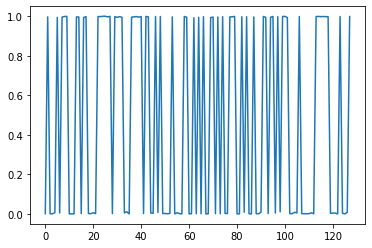

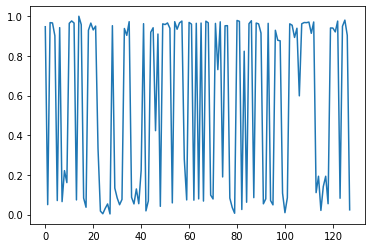

In [22]:
plt.plot(y1[2])
plt.show()
plt.plot(y1[20000])